In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom, betabinom, norm,multivariate_normal

In [ ]:

# Generates the basis function
def phi(x):
    return np.vstack([np.ones_like(x), x]).T
beta = 25.0   # noise precision (low noise)
alpha = 2.0   # prior precision
N_max = 20
a_zero = -0.3
a_one = 0.5
x_train = np.random.uniform(-1, 1, N_max)
t_train = (a_zero + a_one*x_train) + np.random.normal(0, 0.2, N_max)
# Grid over weight space
w0 = np.linspace(-1, 1, 100)
w1 = np.linspace(-1, 1, 100)
W0, W1 = np.meshgrid(w0, w1)
W = np.dstack([W0, W1])

def likelihood_grid(x, t):
    Phi = phi(x)
    # Calculate the likelihood for the given (x,t) pair
    errors = t - (W0[None,:,:] + W1[None,:,:] * x)
    return np.exp(-0.5 * beta * np.sum(errors**2, axis=0))

def posterior_params(x, t):
    # Compute posterior mean and covariance per textbook equations
    Phi = phi(x)
    S_inv = alpha * np.eye(2) + beta * Phi.T @ Phi
    S = np.linalg.inv(S_inv)
    m = beta * S @ Phi.T @ t
    return m, S

# Dataset sizes to visualize
sizes = [0, 1, 2, 20]

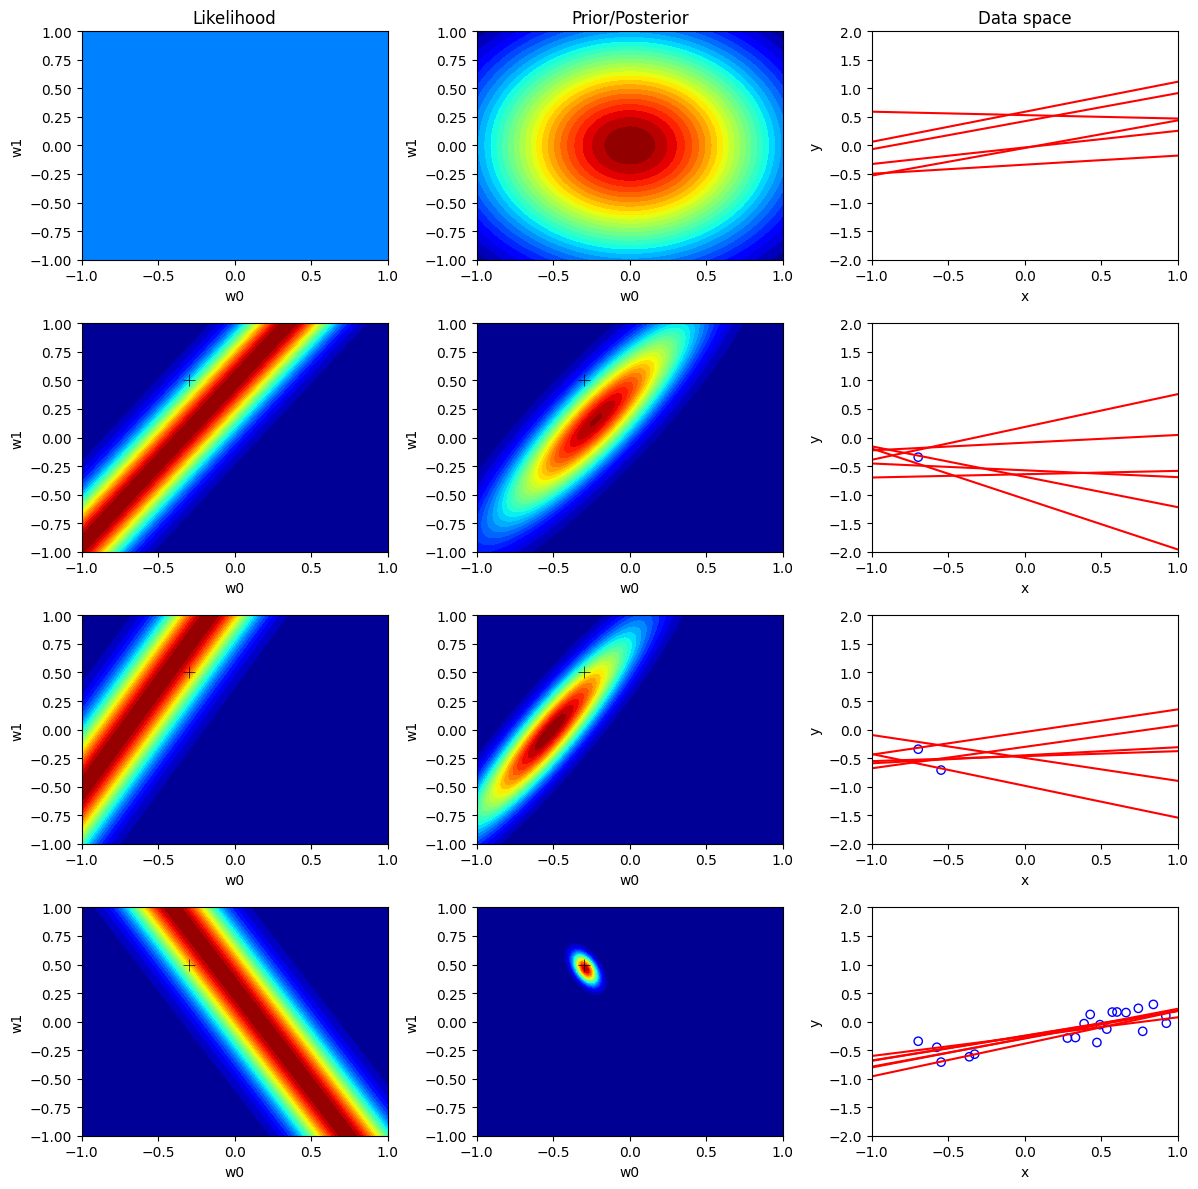

In [3]:
fig, axes = plt.subplots(len(sizes), 3, figsize=(12, 12))

for row, N in enumerate(sizes):
    if N == 0:
        # Prior
        Z_like = np.ones_like(W0)
        rv = multivariate_normal([0,0], (1/alpha)*np.eye(2))
        Z_post = rv.pdf(np.column_stack([W0.ravel(), W1.ravel()])).reshape(W0.shape)
        samples = np.random.multivariate_normal([0,0], (1/alpha)*np.eye(2), 6)
    else:
        xN, tN = x_train[:N], t_train[:N]
        # Likelihood
        Z_like = likelihood_grid(x_train[N-1], t_train[N-1])
        # Posterior
        m, S = posterior_params(xN, tN)
        rv = multivariate_normal(m, S)
        Z_post = rv.pdf(np.column_stack([W0.ravel(), W1.ravel()])).reshape(W0.shape)
        samples = np.random.multivariate_normal(m, S, 6)

    # Likelihood plot
    ax = axes[row, 0]
    ax.contourf(W0, W1, Z_like, levels=30, cmap="jet")
    if N > 0:
        ax.plot(a_zero, a_one, marker='+', markersize=8, color='white', markeredgecolor='black', markeredgewidth=0.5)
    ax.set_xlabel("w0")
    ax.set_ylabel("w1")
    ax.set_title("Likelihood" if row==0 else "")
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

    # Posterior plot
    ax = axes[row, 1]
    ax.contourf(W0, W1, Z_post, levels=30, cmap="jet")
    if N > 0:
        ax.plot(a_zero, a_one, marker='+', markersize=8, color='white', markeredgecolor='black', markeredgewidth=0.5)
    ax.set_title("Prior/Posterior" if row==0 else "")
    ax.set_xlabel("w0")
    ax.set_ylabel("w1")
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

    # Data space
    ax = axes[row, 2]
    X_plot = np.linspace(-1, 1, 100)
    if N > 0:
        ax.scatter(xN, tN, facecolors='none', edgecolors='b')
    for s in samples:
        y_plot = s[0] + s[1] * X_plot
        ax.plot(X_plot, y_plot, 'r')
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.set_xlim(-1,1); ax.set_ylim(-2,2)
    ax.set_title("Data space" if row==0 else "")

plt.tight_layout()
plt.show()

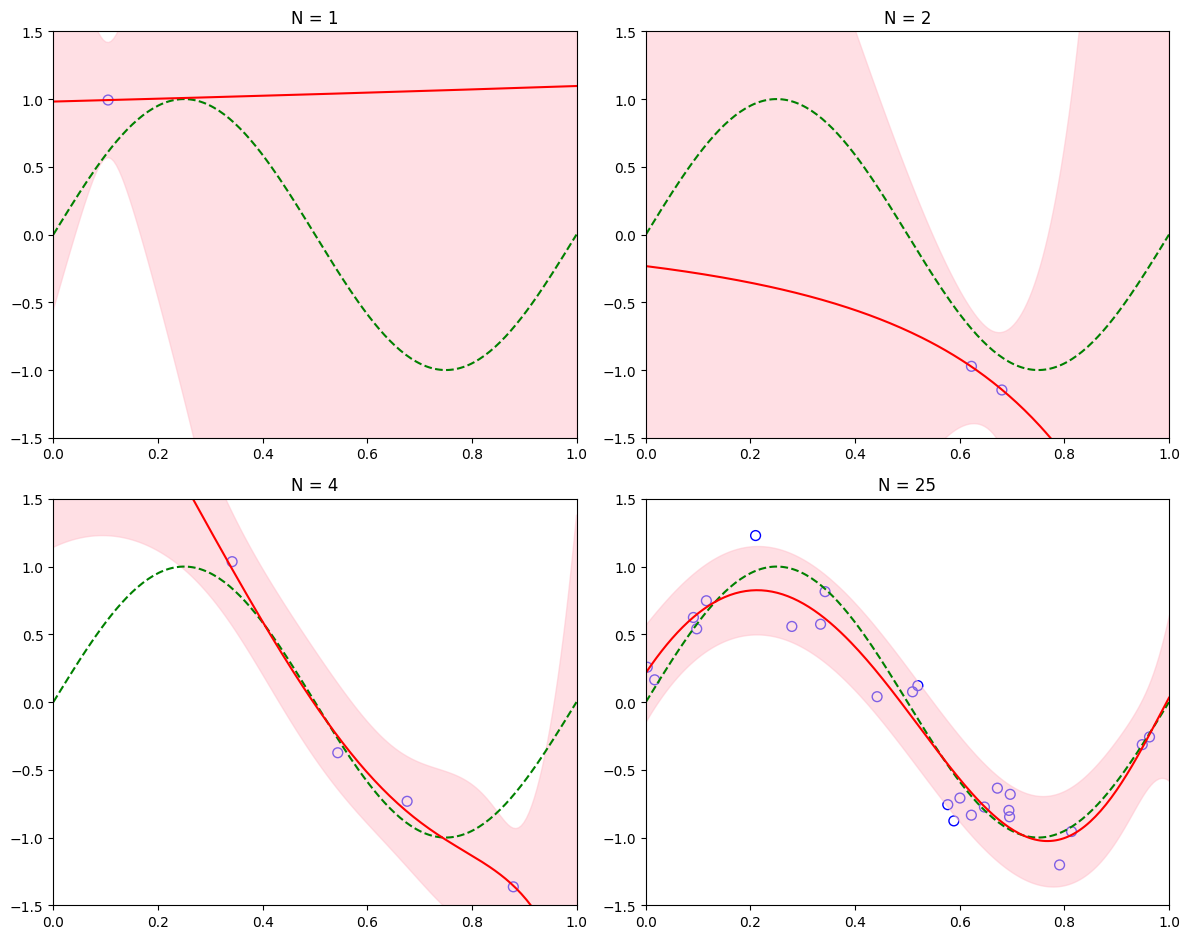

In [15]:
# True function
def f(x):
    return np.sin(2 * np.pi * x)

# Polynomial basis function (M = 9 by default)
def design_matrix(x, M):
    return np.vstack([x**i for i in range(M+1)]).T

# Bayesian linear regression predictive distribution
def bayesian_predictive(x, x_train, t_train, M, alpha, beta):
    Phi = design_matrix(x_train, M)
    S_N_inv = alpha * np.eye(M+1) + beta * Phi.T @ Phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ Phi.T @ t_train

    Phi_x = design_matrix(x, M)
    mean = Phi_x @ m_N
    var = 1/beta + np.sum(Phi_x @ S_N * Phi_x, axis=1)
    return mean, np.sqrt(var)

# Parameters
alpha = 5e-3
beta = 11.1
M = 9

# Training set sizes
N_values = [1, 2, 4, 25]

# Plot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

x_plot = np.linspace(0, 1, 200)
true_y = f(x_plot)

for ax, N in zip(axes.ravel(), N_values):
    # Training data
    x_train = np.random.rand(N)
    t_train = f(x_train) + np.random.normal(0, np.sqrt(1/beta), N)

    # Predictive mean & std
    y_mean, y_std = bayesian_predictive(x_plot, x_train, t_train, M, alpha, beta)

    # Plotting
    ax.plot(x_plot, true_y, 'g--', label="True function")
    ax.scatter(x_train, t_train, facecolor='none', edgecolor='b', s=50, label="Training data")
    ax.plot(x_plot, y_mean, 'r', label="Predictive mean")
    ax.fill_between(x_plot, y_mean - y_std, y_mean + y_std, color='pink', alpha=0.5, label="Uncertainty")

    ax.set_title(f"N = {N}")
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.5, 1.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [5]:
# for m and s calcs, T is an N x K vector where N is number of observations seen so far and K is the target variable. t_k is just a column vector with n*k entries.